Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


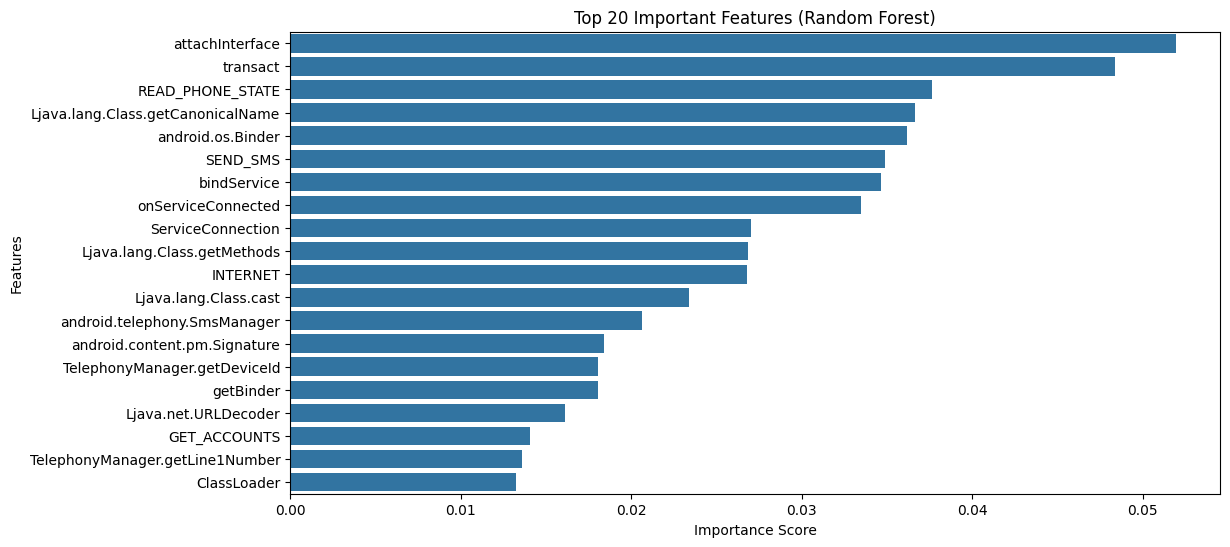

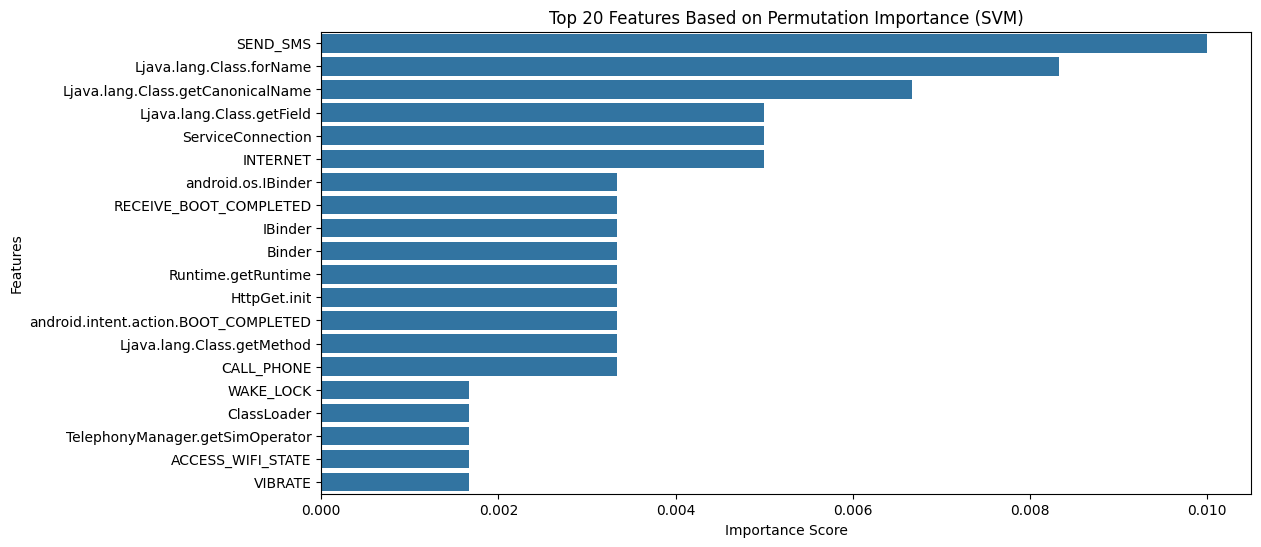

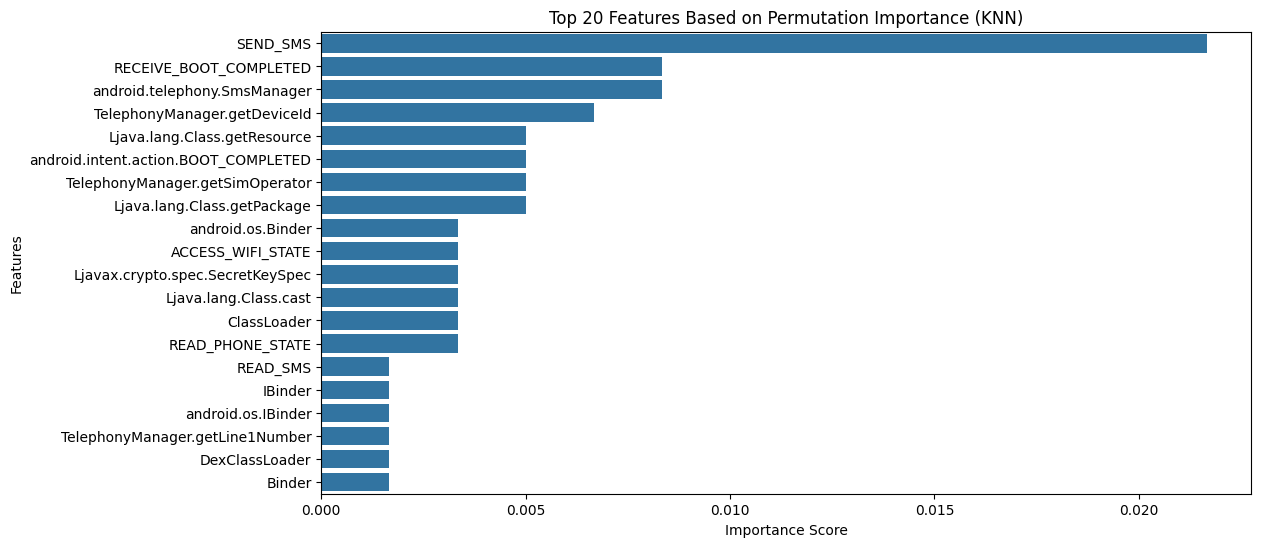

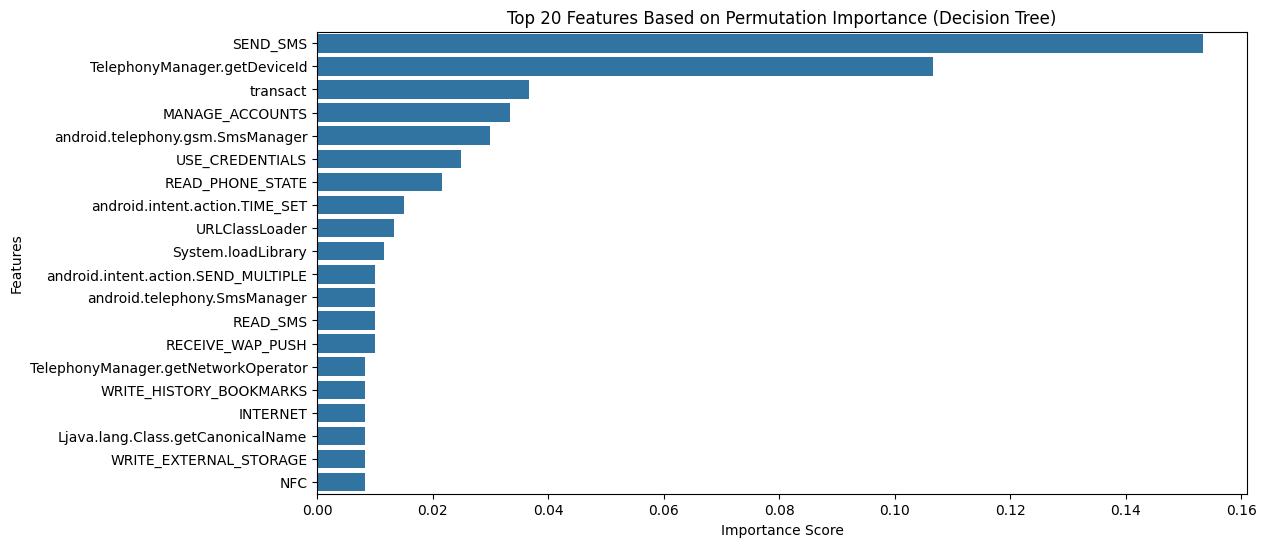

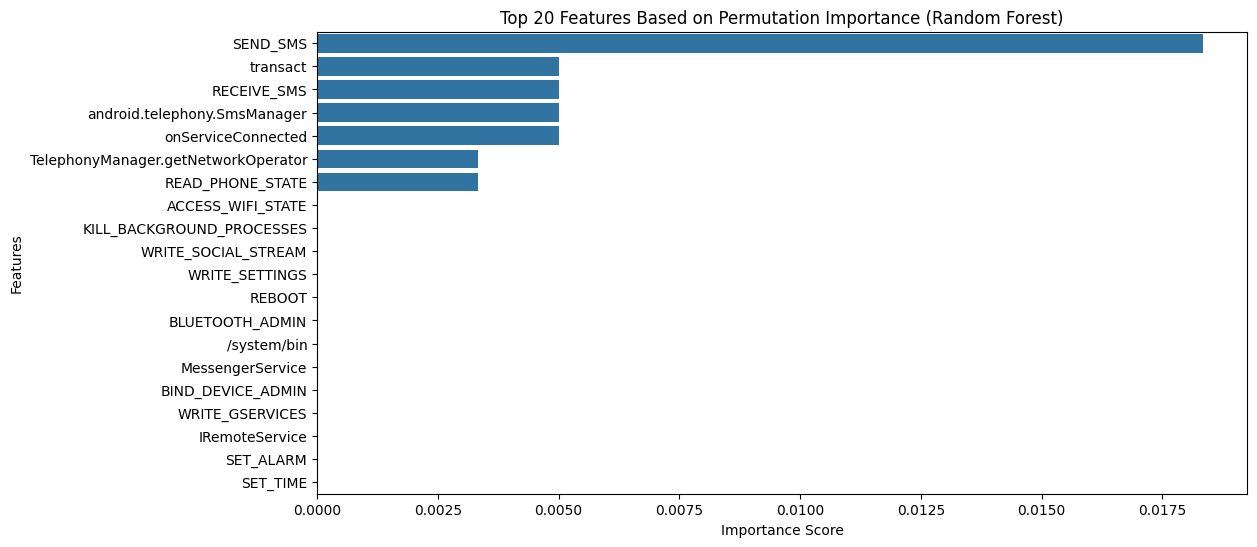

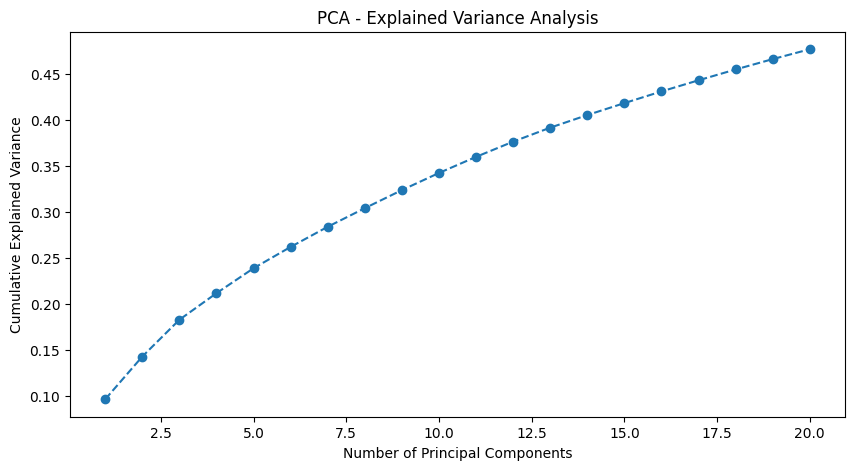

In [ ]:
# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/drebin.csv'
data = pd.read_csv(dataset_path)

# Step 3: Preprocess Data
X = data.drop(columns=['class'])  # Features
y = data['class']  # Target variable

# Encode categorical features
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])

# Convert to numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# Encode the target variable
y = LabelEncoder().fit_transform(y)

# Train-test split (80%-20%)
# Remove stratify if a class has only one sample
if np.min(np.bincount(y)) < 2:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Compute Feature Importance Using Random Forest (Only for Tree-Based Models)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importance scores
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance.Importance[:20], y=feature_importance.Feature[:20])
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Step 5: Compute Permutation Feature Importance (For All Models)
models = {
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    perm_importance = permutation_importance(model, X_test[:200], y_test[:200], n_repeats=3, random_state=42, n_jobs=-1)
    perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
    perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False)

    # Visualize permutation importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x=perm_importance_df.Importance[:20], y=perm_importance_df.Feature[:20])
    plt.title(f"Top 20 Features Based on Permutation Importance ({name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

# Step 6: Apply Principal Component Analysis (PCA) for Dimensionality Reduction
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=20)  # Keep top 20 principal components
X_pca = pca.fit_transform(X_scaled)

# Explained variance plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, 21), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Explained Variance Analysis")
plt.show()